In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K
from datetime import datetime
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/애쓰는 감자/data/Pre3.csv')
# test = pd.read_csv('/content/gdrive/MyDrive/애쓰는 감자/data/test2.csv')

In [ ]:
train,val = train_test_split(data,test_size=.3,random_state=42)

In [ ]:
# X_train = train['BZ_PPOS_ITM_CTT']
# X_test = test['BZ_PPOS_ITM_CTT']

In [ ]:
# y_train = train['mid']

In [ ]:
train

(488387, 5)

In [ ]:
val.isnull().sum()

KEDCD              0
BZ_PPOS_ITM_CTT    1
KSIC10_BZC_CD      0
mid                0
Big                0
dtype: int64

In [ ]:
idx = val[val['BZ_PPOS_ITM_CTT'].isnull()].index

In [ ]:
val2 = val.drop(idx,axis=0)

In [ ]:
import gzip
import pickle
with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/X_train.pickle','rb') as f:
    X_train = pickle.load(f)

In [ ]:
with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/Y_train.pickle','rb') as f:
    Y_train = pickle.load(f)
with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/X_val.pickle','rb') as f:
    X_val = pickle.load(f)
with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/Y_val.pickle','rb') as f:
    Y_val = pickle.load(f)
with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/X_test.pickle','rb') as f:
    X_test = pickle.load(f)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
big_val = val2['Big']
ohe = OneHotEncoder()
bigval_y = ohe.fit_transform(big_val.values.reshape(-1,1)).toarray()

In [ ]:
with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/preprocessing_data/bigval_y.pickle', 'wb') as f:
    pickle.dump(bigval_y, f)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 11
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 53868
등장 빈도가 10번 이하인 희귀 단어의 수: 35211
단어 집합에서 희귀 단어의 비율: 65.36533749164624
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.2151456716624007


In [ ]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18658


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size) # num_words = vocab_size
tokenizer.fit_on_texts(X_train)
token_X_train = tokenizer.texts_to_sequences(X_train)
token_X_test = tokenizer.texts_to_sequences(X_val)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train = ohe.fit_transform(Y_train.values.reshape(-1,1)).toarray()

In [ ]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = np.delete(y_train, drop_train, axis=0)
print(len(del_X_train))
print(len(del_y_train))

1139566
1139566


train data의 최대 길이 : 2990
train data의 평균 길이 : 41.64975789028455


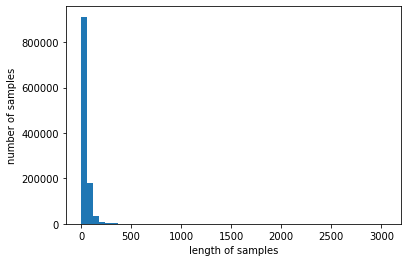

In [ ]:
import matplotlib.pyplot as plt
print('train data의 최대 길이 :',max(len(l) for l in del_X_train))
print('train data의 평균 길이 :',sum(map(len, del_X_train))/len(del_X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 300
below_threshold_len(max_len, del_X_train)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 99.74727220713851


In [ ]:
# with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/preprocessing_data/del_y_train.pickle', 'wb') as f:
#     pickle.dump(del_y_train, f)

In [ ]:
# with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/del_X_train.pickle', 'wb') as f:
#     pickle.dump(del_X_train, f)

In [ ]:
with gzip.open('/content/gdrive/MyDrive/애쓰는 감자/data/token_X_val.pickle', 'wb') as f:
    pickle.dump(token_X_test, f)

In [ ]:
pad_X_train = pad_sequences(del_X_train, maxlen = max_len)
pad_X_test = pad_sequences(token_X_test, maxlen = max_len)